# Задание 6. GLM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.stats as sts
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
!pip install -U scikit-learn

In [ ]:
from sklearn.linear_model import LogisticRegression, TweedieRegressor, PoissonRegressor

In [ ]:
import sklearn
ver = sklearn.__version__
ver

'0.23.2'

## Задание 0. Написать своими словами про максимальное правдоподобие и GLM. 


#### Максимальное правдоподобие

До этого оценивали параметры модели, минимизируя среднеквадратическую ошибку, но можно еще это сделать, максимизируя правдоподобие данных. Цель максимального правдоподобия - сделать так, чтобы наша модель максимально соответствовала той или иной модели распределения. То есть мы пытаемся привести наши данные к виду какого-то распределения (гамма, твиди, Пуассона, Бернулли...). Накладываем модель распределения на наши данные, передвигаем её (с помощью параметров, которые мы максимизируем) и смотрим, при каком положении есть максимальная вероятность наблюдать наши данные. 

#### GLM

Линейная регрессия предполагает, что выход распределяется по Гауссу - но в случае с датасетом breast_cancer мы получаем категории (malignant-benign) и др. GLM как бы дополняет линейную регрессию, чтобы можно было сделать модели, выход которых не может быть представлен гауссовым распределением. 

## Задание 1. Оценка моделей

### Third-party liability и распределение Пуассона, гамма-, твиди-распределения

In [ ]:
from sklearn.datasets import fetch_openml
liab_data = fetch_openml(data_id=41214, as_frame=True).frame

In [ ]:
sns.pairplot(liab_data)

Нужно предсказывать Pure Premium (Твиди) - сумма, которую страховщик должен выплатить застрахованному лицу на единицу Exposure. Для этого предсказывать частоту обращений (Пуассон) * средняя сумма выплаты на обращение (Гамма)

Количество обращений застрахованного (ClaimNb) лица принимает целочесленные значения, можем использовать распределение Пуассона - когда события происходят независимо друг от друга, с определенной интенсивностью за определенный промежуток времени (Exposure)

Добавим столбец частоты обращений - количество обращений на срок до окончания страховки

In [ ]:
liab_data["Frequency"] = liab_data["ClaimNb"] / liab_data["Exposure"]

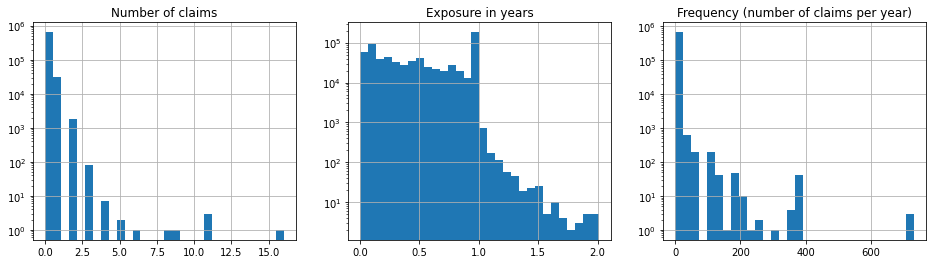

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Number of claims")
_ = liab_data["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = liab_data["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = liab_data["Frequency"].hist(bins=30, log=True, ax=ax2)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer

#нужно сделать так, чтобы значения всех остальных колонок (не Exposure, Frequency, ClaimNb) были float (иначе ошибка в след. блоке кода)
log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False),
    StandardScaler()
)

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough",
            ["BonusMalus"]),
        ("binned_numeric", KBinsDiscretizer(n_bins=10),
            ["VehAge", "DrivAge"]),
        ("log_scaled_numeric", log_scale_transformer,
            ["Density"]),
        ("onehot_categorical", OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
    ],
    remainder="drop",
)

In [ ]:
# получаем трейнинг сет для пуассона
liab_data_train, liab_data_test = sklearn.model_selection.train_test_split(liab_data, test_size=0.33, random_state=0)
poisson_glm = sklearn.pipeline.Pipeline([
    ("preprocessor", linear_model_preprocessor),
    ("regressor", PoissonRegressor(alpha=1e-12, max_iter=300))
])
poisson_glm.fit(liab_data_train, liab_data_train["Frequency"],
                regressor__sample_weight=liab_data_train["Exposure"])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('passthrough_numeric',
                                                  'passthrough',
                                                  ['BonusMalus']),
                                                 ('binned_numeric',
                                                  KBinsDiscretizer(n_bins=10),
                                                  ['VehAge', 'DrivAge']),
                                                 ('log_scaled_numeric',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Density']),
                                 

In [ ]:
predicted = poisson_glm.predict(liab_data_train)

???? Как оценить модель?? Так же, как линейную регрессию?

## Задание 2.  Найти на каггле датасеты, для разных семейств  GLM моделей

1. https://www.kaggle.com/c/bike-sharing-demand/data - Пуассон. "You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period" - нужно предсказать целочисленное неотрицательное значение.
2. https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction - Биномиальное. "whether the customer would be interested in Vehicle insurance" - два варианта выхода, заинтересован или нет.
3. https://www.kaggle.com/rajanand/rainfall-in-india - Гамма. Можно предсказать, какое количество дождя выпадет за месяц в определенный сезон - если Гамма-распределение рассматривать как время между распределенными по Пуассону событиями
4. См. выше - Твиди. Предсказывать общее количество осадков за год - Пуассон * Гамма.